In [1]:
import os
import sys
# add your module path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# change your base path
os.chdir('../')
print(os.getcwd())

/home/yoyee/Documents/deepSfm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import torch
from Val_model_heatmap import Val_model_heatmap
import tqdm
from utils.utils import toNumpy

filename = 'configs/magicpoint_repeatability_heatmap.yaml'
import yaml
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.set_default_tensor_type(torch.FloatTensor)
with open(filename, 'r') as f:
    config = yaml.load(f)

task = config['data']['dataset']
# data loading
from utils.loader import dataLoader_test as dataLoader
data = dataLoader(config, dataset='hpatches')
test_set, test_loader = data['test_set'], data['test_loader']

# load frontend
val_agent = Val_model_heatmap(config['model'], device=device)

# take one sample
img_patch_size = 17
pred_patch_size = 9
# for i, sample in tqdm(enumerate(test_loader)):
for i, sample in enumerate(test_loader):
    if i>1: break


    val_agent.loadModel()
    # points from heatmap
    img = sample['image']
    print("image: ", img.shape)

    heatmap_batch = val_agent.run(img.to(device)) # heatmap: numpy [batch, 1, H, W]
    # heatmap to pts 
    pts = val_agent.heatmap_to_pts()
    # print("pts: ", pts)
    print("pts[0]: ", pts[0].shape)
    print("pts: ", pts[0][:,:3])

    pts_subpixel = val_agent.soft_argmax_points(pts, patch_size=pred_patch_size)
    print("subpixels: ", pts_subpixel[0][:,:3])
    
    img_patches = val_agent.get_image_patches(pts, toNumpy(img), patch_size=img_patch_size)
    print("img_patches: ", img_patches.shape)
    heatmap_patches = val_agent.patches
    print("heatmap_patches: ", heatmap_patches.shape)
    
    
    
    # heatmap, pts to desc
    desc_sparse = val_agent.desc_to_sparseDesc()
    print("desc_sparse[0]: ", desc_sparse[0].shape)

image:  torch.Size([1, 1, 240, 320])
pts[0]:  (3, 518)
pts:  [[ 63.          40.         144.        ]
 [152.         151.          63.        ]
 [  0.59920043   0.50273508   0.48038319]]
not take care of batch! only take first element!
heatmap:  (248, 328)
one times of log!
subpixels:  [[ 63.61997175  39.11931181 143.83192492]
 [151.25406289 151.55682707  63.89126348]
 [  0.59920043   0.50273508   0.48038319]]
heatmap:  (256, 336)
img_patches:  (518, 17, 17)
heatmap_patches:  (518, 9, 9)
desc_sparse[0]:  (256, 518)
image:  torch.Size([1, 1, 240, 320])
pts[0]:  (3, 518)
pts:  [[ 63.          40.         144.        ]
 [152.         151.          63.        ]
 [  0.59920043   0.50273508   0.48038319]]
not take care of batch! only take first element!
heatmap:  (248, 328)
one times of log!
subpixels:  [[ 63.61997175  39.11931181 143.83192492]
 [151.25406289 151.55682707  63.89126348]
 [  0.59920043   0.50273508   0.48038319]]
heatmap:  (256, 336)
img_patches:  (518, 17, 17)
heatmap_patche

In [6]:
# print shape
entries = list(sample)
for i in entries:
    element = sample[i]
#     print(type(element))
    if type(element) is torch.Tensor:
        print("shape of ", i, " ", element.shape)
# img, mask_2D = sample['image'], sample['valid_mask']


shape of  image   torch.Size([1, 1, 240, 320])
shape of  warped_image   torch.Size([1, 1, 240, 320])
shape of  homography   torch.Size([1, 3, 3])


pts:  [ 63.         152.           0.59920043] , pts_subpixel:  [ 63.61997175 151.25406289   0.59920043]
patches[img_id,0,:,:] sum:  -582.43494
patches[img_id,0,:,:] max:  -1.865951
pts:  [ 40.         151.           0.50273508] , pts_subpixel:  [ 39.11931181 151.55682707   0.50273508]
patches[img_id,0,:,:] sum:  -511.2061
patches[img_id,0,:,:] max:  -1.9827126
pts:  [144.          63.           0.48038319] , pts_subpixel:  [143.83192492  63.89126348   0.48038319]
patches[img_id,0,:,:] sum:  -577.56976
patches[img_id,0,:,:] max:  -1.8435541
pts:  [79.         96.          0.47854638] , pts_subpixel:  [79.93989134 95.29714274  0.47854638]
patches[img_id,0,:,:] sum:  -512.1616
patches[img_id,0,:,:] max:  -1.9709961
pts:  [64.         96.          0.46878481] , pts_subpixel:  [63.56914401 95.09314442  0.46878481]
patches[img_id,0,:,:] sum:  -522.0301
patches[img_id,0,:,:] max:  -2.0479612
pts:  [136.          15.           0.46290714] , pts_subpixel:  [135.78366232  16.21709156   0.462907

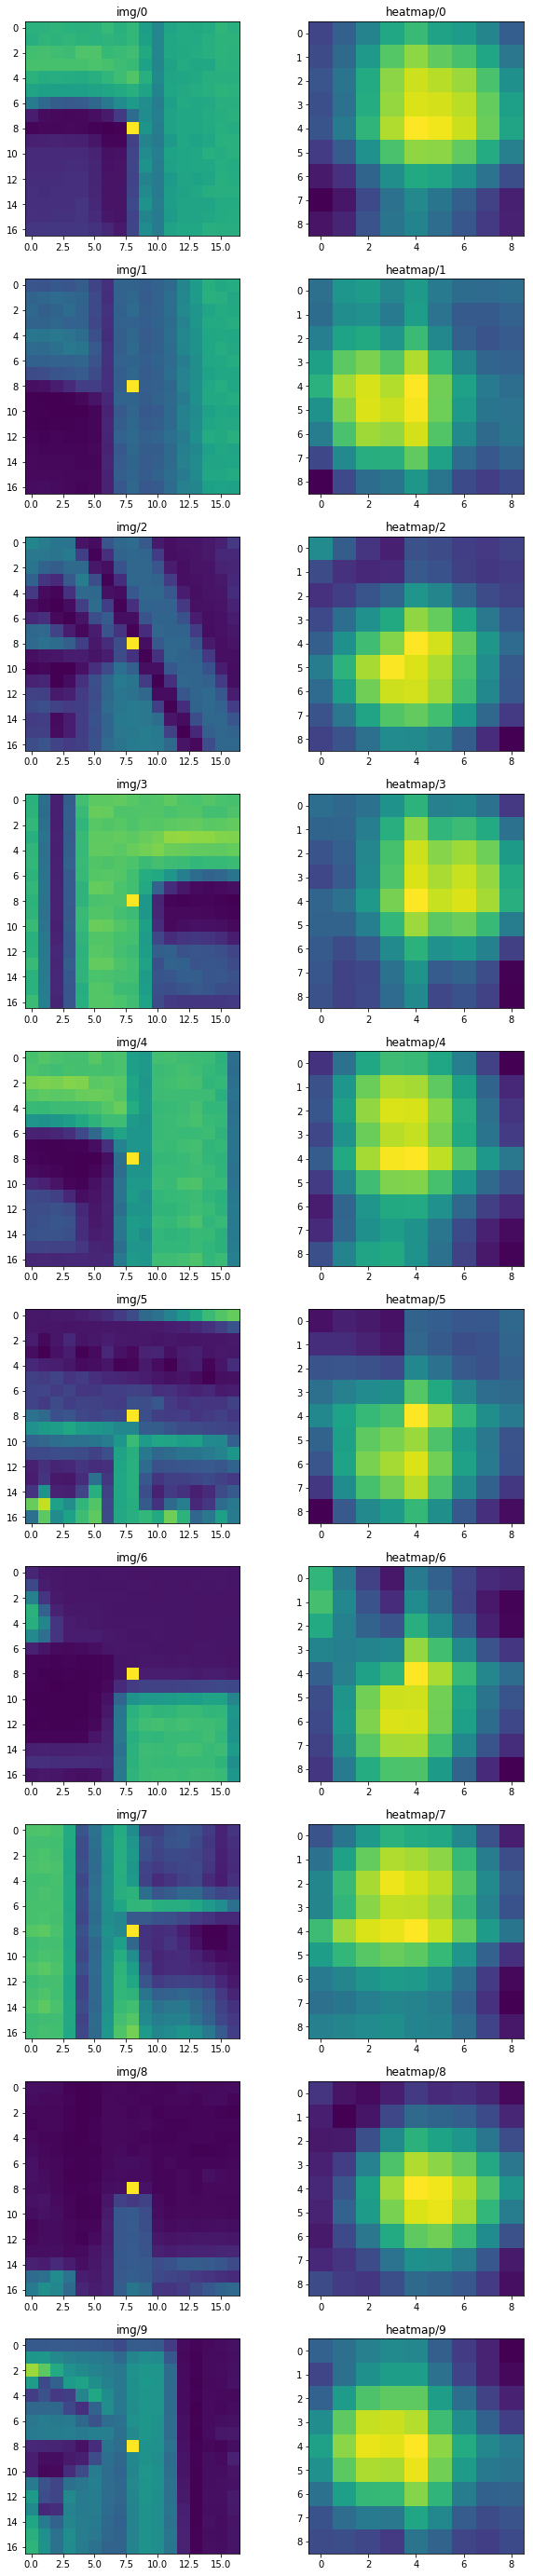

In [7]:
images_num = 10 # 50
rows = images_num
scale = 5
cols = 2
plt.figure(figsize=(cols*scale, rows*scale))
count = 1

for i in range(images_num):
    img_id = i
#     print("res (x, y): ", points_res[i])
#     plt.imshow(draw_center(toNumpy(patches[img_id,0,:,:]), 4))
    p = img_patches[img_id,:,:]
    p[img_patch_size//2, img_patch_size//2] = 1
    plt.subplot(rows, cols, count)
    plt.imshow(p)
    count += 1
    plt.title('img/' + str(i))
    
    p = heatmap_patches[img_id,:,:]
    plt.subplot(rows, cols, count)
    plt.imshow(p)
    count += 1
    plt.title('heatmap/' + str(i))
    print("pts: ", pts[0][:,i], ", pts_subpixel: ", pts_subpixel[0][:,i])
    print("patches[img_id,0,:,:] sum: ", p.sum())
    print("patches[img_id,0,:,:] max: ", p.max())
    
#     print("patches[img_id,0,:,:]: ", p)

plt.show()

pts_pred:  (518, 3)


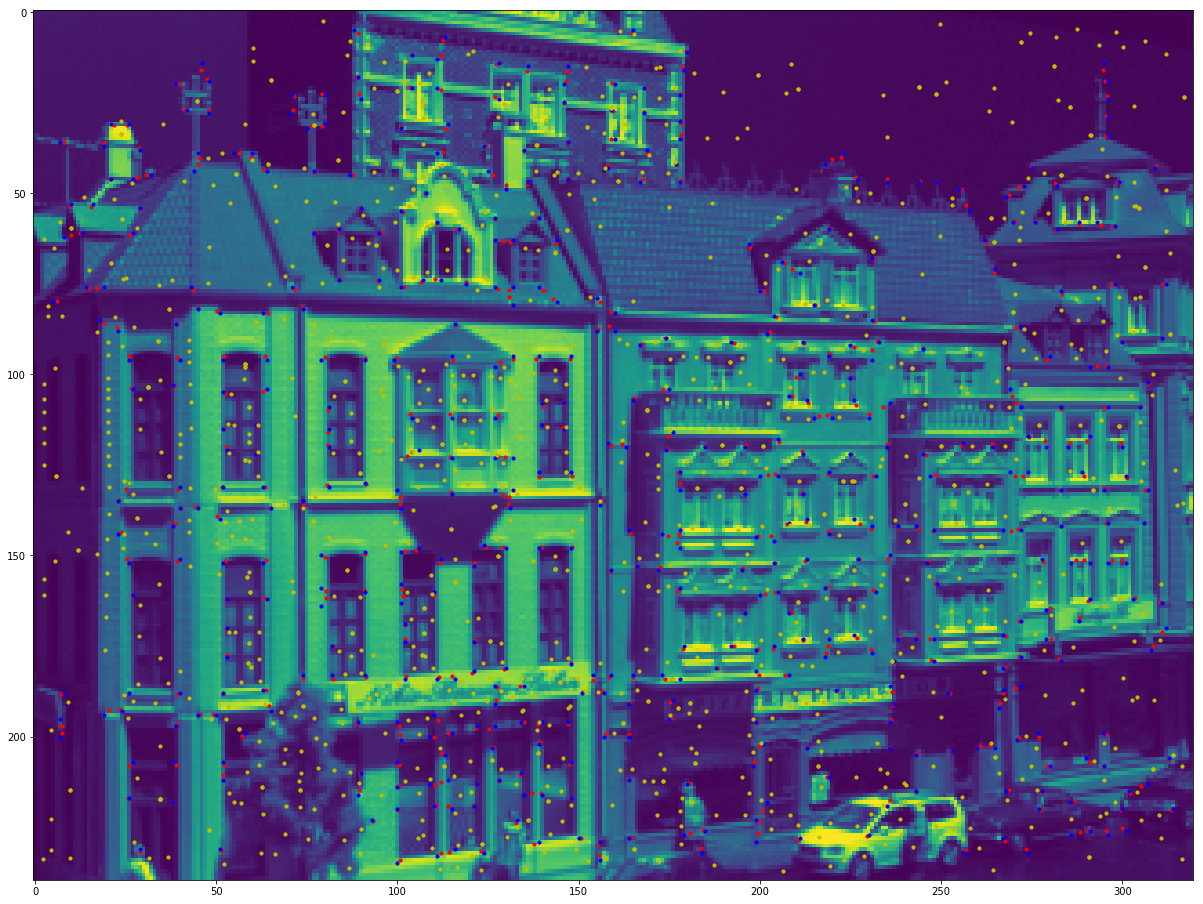

In [18]:
img_np = img.squeeze().numpy()
plt.figure(figsize=(120, 16))
plt.imshow(img_np)
pts_pred = pts_subpixel[0].transpose()
print("pts_pred: ", pts_pred.shape)
# subpixel
plt.scatter(pts_pred[:, 0], pts_pred[:, 1], s=10, marker='o', c='r')

# pixel
pts_pred = pts[0].transpose()
plt.scatter(pts_pred[:, 0], pts_pred[:, 1], s=10, marker='o', c='b')

# sift
pts_pred = pts_sift
plt.scatter(pts_pred[:, 0], pts_pred[:, 1], s=10, marker='o', c='y')
plt.show()

float32


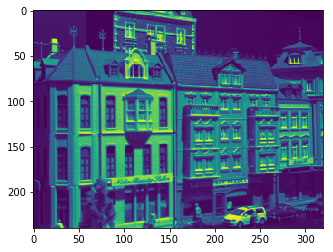

pts_sift:  (1150, 2)


In [13]:
import cv2
def SIFT_det(img, img_rgb, visualize=False, nfeatures=2000):
    # Initiate SIFT detector
    # pip install opencv-python==3.4.2.16, opencv-contrib-python==3.4.2.16
    # https://www.pyimagesearch.com/2015/07/16/where-did-sift-and-surf-go-in-opencv-3/
    sift = cv2.xfeatures2d.SIFT_create(contrastThreshold=1e-5)

    # find the keypoints and descriptors with SIFT
    kp, des = sift.detectAndCompute(img,None)
    # print("# kps: {}, descriptors: {}".format(len(kp), des.shape))
    x_all = np.array([p.pt for p in kp])

    if visualize:
        plt.figure(figsize=(30, 4))
        plt.imshow(img_rgb)
        plt.scatter(x_all[:, 0], x_all[:, 1], s=10, marker='o', c='y')
        plt.show()

    return x_all, kp, des

print(img_np.dtype)
plt.imshow(img_np)
plt.show()
# togray = lambda image: cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
pts_sift, kp, des = SIFT_det((img_np*255).astype(np.uint8), img_np)
print("pts_sift: ", pts_sift.shape)

In [ ]:
img_np.astype(np.double)